In [13]:
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont
import os
import glob
from datetime import datetime, timezone, timedelta

# For movie processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# built-in modules
import itertools as it

%matplotlib inline

# Various globals
img = []; images = []; imgid = 0
imgfmt = "rgb"
imgname = ""
meth = 0; methch = 0
thresh = [(40,100), (170,240)]
winname = 'fit line'
invcnt = 0
model_left_fit = []; model_right_fit = []
pipeline_lbls = ["_pp_Undistort", "_pp_Threshold", "_pp_Warp", "_pp_LaneFind", "_pp_Unwarp", "_pp_Final"]
lcrad = 0; rcrad = 0; carpos = []
output_dir = "output_images/"

# ###############################################################
#
# ############ VARIOUS VISUALIZATION AND PRINT ROUTINES
#
def plot_corners(img, chlay, corners):
    cv2.drawChessboardCorners(img, chlay, corners, True)
    cv2.imshow(img)

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    # `img` is the output of the hough_lines(), An image with lines drawn on it.
    #       Should be a blank image (all black) with lines drawn on it.
    # `initial_img` should be the image before any processing.
    # The result image is computed as follows:
    # initial_img * α + img * β + γ
    # NOTE: initial_img and img must be the same shape!
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Plot 2 images side by side
def visualize_imgs(img1, img2, tit1, tit2):
    # Visualize before and after images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1); ax1.set_title(tit1, fontsize=30)
    ax2.imshow(img2); ax2.set_title(tit2, fontsize=30)

def toint(p):
    return tuple(map(int, p))

# Given a list of points, plot them
def plot_pts(img, lnpts, color=[255,255,255], sz=1):
    for p in lnpts:
        # print (type(p), p.ndim, p.shape, type(p[0]), type(p[1]))
        # if ((p[0] > 700 and p[0] < 900) and (p[1] > 400 and p[1] < 550)):
        cv2.circle(img, toint(p), sz, color, -1)

# Put a string on an image
def draw_str(img, target, s):
    x, y = target
    cv2.putText(img, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(img, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)

# Given an array of points plot them on a blank image
# This is used to plot the "fitting" polygonal envelope representing the lane regions
#
# Returns a 3-D image
def draw_fit_polygon(imgdim0, imgdim1, left_fitx, right_fitx, ploty, margin, color=[0,255,0]):
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    window_img = np.zeros((imgdim0,imgdim1,3), dtype=np.uint8)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), color)
    cv2.fillPoly(window_img, np.int_([right_line_pts]), color)

    return window_img

# Draw an image overlaid with name of image
def draw_img(imgname, img):
    global winname

    if imgfmt == "bgr" and img.ndim == 3:
        imgcopy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        imgcopy = np.copy(img)
    draw_str(imgcopy, (40, 20), imgname)
    # hpos = int(imgdim[1]*0.60)
    # draw_str(img, (hpos, 20), "( " + str(tmin) + ", " + str(tmax) + " )")
    # cv2.imshow(winname, imgcopy)
    plt.imshow(imgcopy)
    
# Print the timings for the various stages of the pipeline. Used to evaluate performance
def print_times(tvals, inv=-1):
    labels = [ " NONE ", " THR: ", ". PERS: ", ". LANE: ", ". XPER: ", ". FIN: " ]
    ostr = "" if inv < 0 else str(inv)+">> "
    tms = tvals[0]
    for t in range(1, len(tvals)):
        tmt = tvals[t]
        ostr += labels[t] + str((tmt-tms).microseconds // 1000)
    print (ostr)


# ############################################
#
# ######   CAMERA CALIBRATION 
#
def calib_camera():
    # for each chessboard pattern
    #.  read_img
    #.  convert to gray
    #.  findChessCorners
    #.  append corners to imgpoints
    # call calibrateCamera
    chlay = (9,6)
    i,nowtest = 0,-1
    retcorn = []
    objpts = []; imgpts = []
    savecorners = False


    cfiles = glob.glob("camera_cal/cal*.jpg")
    for i, cfile in enumerate(cfiles): 
        # calibration1 is a 9x5, cal*4 is a 7x4, cal*5 is a 7x6.
        if (cfile == "camera_cal/calibration1.jpg"):
            chlay = (9,5)
            savecorners = True
        elif (cfile == "camera_cal/calibration4.jpg"):
            chlay = (7,4)
        elif (cfile == "camera_cal/calibration5.jpg"):
            chlay = (7,6)
        else:
            chlay = (9,6)
        # print ("Attempting " + cfile)
        if (nowtest == -1 or i == nowtest):
            img = cv2.imread(cfile)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, chlay, None)
            if (ret):
                imgpts.append(corners)
                if (savecorners):
                    retcorn = corners
                    # print("Found the corners to be ", corners)
                    savecorners = False
                ccoord = np.zeros((chlay[0]*chlay[1],3), np.float32)
                ccoord[:,:2] = np.mgrid[:chlay[0], :chlay[1]].T.reshape(-1,2)
                objpts.append(ccoord)
                # plot_corners(img, chlay, corners)
            else:
                print("Failed to find the corners for ", cfile)

    if (len(imgpts) > 0):
        imgsz = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, imgsz, None,None)
        print ("Calibration ", "successful" if ret else "failed", ". Obtained ", len(imgpts), " calibrations from ", (i+1), " files")
        return ret, mtx, dist
    return (False, None, None)


# ######################## 
#
#     THRESHOLDING / FILTERING OPERATIONS
#
def apply_colorfilter(img):
    global imgfmt

    # Lanes are typically yellow (strong R/G) and white (strong R/G/B)
    # So filter out any that are below. This should take out the blacks / blues / darker colors
    rthresh, gthresh = (210, 210)
    ridx = 0 if imgfmt == "rbg" else 2
    gidx = 1

    rfiltered = (img[:,:,ridx] <= rthresh)
    gfiltered = (img[:,:,gidx] <= gthresh)
    rgfiltered = rfiltered | gfiltered
    colfilt = np.copy(img)
    colfilt [ rgfiltered ] = [ 0, 0, 0 ]
    # colfilt = np.zeros_like(img)
    # for i in range(rfiltered.shape[0]):
        # for j in range(rfiltered.shape[1]):
            # if (rfiltered[i][j] and gfiltered[i][j]):
                # colfilt[i][j] = img[i][j]
    # colfilt[:,:, = np.where(rfiltered & gfiltered, img, np.zeros_like(img) )
    return colfilt


# Apply the Sobel transformation and filter out "weak" pixels to help isolate lanes
# Returns a binary image
def apply_sobel(img, tmin, tmax):
    global imgfmt, globcfg

    wimg = apply_colorfilter(img) if globcfg["colfilt"] else img

    cxform = cv2.COLOR_RGB2GRAY if (imgfmt == "rgb") else cv2.COLOR_BGR2GRAY 
    gray = cv2.cvtColor(wimg, cxform)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= tmin) & (scaled_sobel <= tmax)] = 255
    return sxbinary

# Filter image based on the saturation of the pixels
# Returns a binary image
def apply_satthresh(img, tmin, tmax):
    global imgfmt

    wimg = img
    cxform = cv2.COLOR_RGB2HLS if (imgfmt == "rgb") else cv2.COLOR_BGR2HLS 
    hls = cv2.cvtColor(wimg, cxform)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= tmin) & (s_channel <= tmax) ] = 255

    return s_binary

# An indirection routine
# Not very helpful right now, but could be useful when applying multiple levels of HLS filteration
def apply_hlsthresh(img, tmin, tmax):
    return apply_satthresh(img, tmin, tmax)

# The thresholding stage of the pipeline
# Applies sobel and sat filtration and masks out portions of image not of interest (typically the top half and some sides)
# Returns a binary image
def thresholding(img):
    global thresh, winname
    
    # Apply Sobel
    tmin, tmax = thresh[0]
    # print ("Sobel - applying thresholds: ", tmin, tmax)
    oimg_c = apply_sobel(img, tmin, tmax)

    tmin, tmax = thresh[1]
    # print ("Satn - applying thresholds: ", tmin, tmax)
    oimg_s = apply_hlsthresh(img, tmin, tmax)

    # Combined binary from the 2 thresholdings
    oimg = np.zeros_like(oimg_c)
    oimg[(oimg_c == 255) | (oimg_s == 255)] = 255

    # print ("Sobel: ", np.sum(oimg_c), " L/S: ", np.sum(oimg_s), " Final: ", np.sum(oimg))

    oimg = apply_region_of_interest(oimg, 't')

    return oimg

# #####################
#
#     MASKING
#
# Given an image and a set of vertices defining a polygon, retains image within the polygon
def region_of_interest(img, vertices):
    # Applies an image mask.
    # Only keeps the region of the image defined by the polygon
    # formed from `vertices`. The rest of the image is set to black.
    # `vertices` should be a numpy array of integer points.

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by \"vertices\" with the fill color    \n",
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Mask out portions of an image
# Determines the boundaries of the mask by type of masking desired: 'r' - rectangular, or 't' - trapezoidal
# Returns a masked image of the same shape as the input
def apply_region_of_interest(img, type='t'):
    xlmt = img.shape[1]
    ylmt = img.shape[0]

    if (type == 't'):
        if (xlmt & 0x1): xlmt -= 1
        xtopmrg = int(xlmt/10); xbotmrg = xtopmrg
        xbotmrg = 0
        xtopmrg = 0


        tlt = [int(xlmt/2-xtopmrg),int(ylmt//2)]
        trt = [int(xlmt/2+xtopmrg),int(ylmt//2)]
        blt = [xbotmrg, ylmt]
        brt = [xlmt,ylmt]
    elif (type == 'r'):
        tlt = [0,int(ylmt/2)]
        blt = [0, ylmt]
        trt = [xlmt,int(ylmt/2)]
        brt = [xlmt,ylmt]

    intpoly = np.array([[blt,tlt,trt,brt]])
    return region_of_interest(img, intpoly)


# #####################
#
#     PERSPECTIVE
#
#
# Given a set of src and dst points, determine the perspective transform matrix and apply it to the input img
#
# Returns a "warped" image of the same shape as the input
def apply_pers_chg(img, src, dst, dir=1):

    # Grab the image shape
    xlmt = img.shape[1]
    ylmt = img.shape[0]
    img_size = (xlmt, ylmt)

    if dir == 1:
        # Given src and dst points, calculate the perspective transform matrix
        # print ("Using src as ", src); print ("Using dst as ", dst)
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

def topt(x):
    return (int(x[0]), int(x[1])) if (x.shape[0] == 2) else (0,0)

# Apply a perspective transform
# Uses a fixed set of points (manually determined) for the perspective transform
#
# Returns a "warped" image
def chg_perspective(img, dir=1):

    src = np.float32([(450, 450), (900, 450), (300, 630), (1100, 630) ])
    dst = np.float32([(170, 210), (1180, 210), (500, 680), (900, 680) ])

    warped = apply_pers_chg(img, src, dst, dir)

    return warped


# Imprint img with the curvature and car position details
def imprint_curvature(img):
    global lcrad, rcrad, carpos

    lx = carpos[0]; rx = carpos[1]; 
    px2m = (rx-lx)/3.7  ; # Given lanes are 3.7m wide

    carpxpos = int(((lx + rx)//2) - (img.shape[1]//2))
    lcradstr = str(round(lcrad / px2m, 1)); rcradstr = str(round(rcrad / px2m, 1))
    curvestr = "LtCurve Rad: " + lcradstr + "m RtCurve Rad: " + rcradstr + "m carpxpos: " + str(round(carpxpos/px2m, 2)) + "m"
    curvestr = curvestr + (" left" if (carpxpos < 0) else " right")
    draw_str(img, (20, 20), curvestr)
    return img

# Given a set of points, find the curvature
def measure_curvature_pixels(ploty, left_fit, right_fit):
    global lcrad, rcrad, carpos

    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate the curvatures for the left and the right fits
    l_A = left_fit[0]; l_B = left_fit[1]
    lcrad = int(( (1 + (2*l_A * y_eval + l_B)**2)**(3/2)) / abs(2 * l_A))
    r_A = right_fit[0]; r_B = right_fit[1]
    rcrad = int(( (1 + (2*r_A * y_eval + r_B)**2)**(3/2)) / abs(2 * r_A))
    
    # Determine the car position as the center of the lanes
    lx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    rx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    carpos = [lx, rx]

    return lcrad, rcrad, carpos



# #####################
#
#     LANE FINDING - Polynomial Fit/Histogram routines
#
#
# Given a histogram, find the region of the histogram that has the maximum strength
# Frames with solid shadows can result in histogram peaks and sometimes these peaks were stronger than
# the lane peaks. However, lane peaks showed wider strength than the shadow peaks
# Used this function to convolve and find regions of maximum strength
def get_convolved_histpeaks(lbl, histogram):
    window_width = 40
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    pk = np.int(np.argmax(np.convolve(window,histogram)) - window_width/2)
    pk = 0 if (pk < 0) else pk

    # print (lbl + " alt peak ", pk)
    return pk

# Given an image, estimate lane positions by determining the histogram peaks
def get_histpeaks(binary_warped):

    # Consider the bottom third of the window
    histht = (2*binary_warped.shape[0])//3

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[histht:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midp = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midp])
    rightx_base = np.argmax(histogram[midp:]) + midp

    leftx_base = get_convolved_histpeaks("Left", histogram[:midp])
    rightx_base = get_convolved_histpeaks("right", histogram[midp:]) + midp

    # print ("Found Histogram Peaks at ", leftx_base, "(", histogram[leftx_base], ") ", rightx_base, "(", histogram[rightx_base], ")")
    # print ("Could also use", alt_lb, alt_rb, type(alt_lb), type(alt_rb))
    # print (histogram[:midp])

    return (leftx_base, rightx_base)

# Given the current window centers, determine the window centers for the next strip
# Typically, the next centers are the average of the current window's x-pos provided the current window has enough pixels
# else use the last known polygon fit to determine the x-pos
def get_next_win_centers(nonzerox, inds, curr, lastfit, yhi, ylo):
    # Set minimum number of pixels found to recenter window
    minpix = 50

    ### If found > minpix pixels, recenter next window ###
    ### (`rightx_current` or `leftx_current`) on their mean position ###
    if (len(inds) > 0 and (inds.shape[0] > minpix)):
        curr = int(np.average(nonzerox[inds]))
    else:
        if len(lastfit) > 0 and ylo > 0:
            xhi = lastfit[0]*yhi**2 + lastfit[1]*yhi + lastfit[2]
            xlo = lastfit[0]*ylo**2 + lastfit[1]*ylo + lastfit[2]
            # print ("Curr ", curr, " Would have returned: ", (xhi+xlo)//2, " for ", xhi, " @ ", yhi, " and ", xlo, " for lo @ ", ylo)
            # Make sure the vlaue determined is within range of the last value
            # 200 - empirically determined
            if (abs(xhi-curr) <= 200):
                curr = np.int(xhi)

    return curr

# Use a sliding window to determine all the pixels that represent the left and right lanes
# Find centers of feasible lane positions at the bottom of the image
#    centers may be found using histogram or the last known polynomial fitting the image
# Find possible lane pixels in a box around the centers
# Using the pixels found in the current box, determine the box position in the strip above
# Do so for the entire image
#
# Returns arrays containing the X and Y coordinates of pixesl that form the left and right lanes 
# Additionally, returns a 3-D image with the windows and the pixels drawn if requested
def find_lane_pixels_bywin(binary_warped, leftx_base, rightx_base, nonzero, nonzerox, nonzeroy):
    global model_left_fit, model_right_fit, globcfg

    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = np.zeros((binary_warped.shape[0], binary_warped.shape[1], 3), dtype=np.uint8)

    # HYPERPARAMETERS
    # Choose the number of sliding windows and thus the height of each slice
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Set the width of the windows +/- margin
    margin = 50

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        ### Find the four below boundaries of the window ###
        win_xl_lo = leftx_current-margin
        win_xl_hi = leftx_current+margin
        win_xr_lo = rightx_current-margin
        win_xr_hi = rightx_current+margin
        
        # Draw the windows on the visualization image
        if (globcfg["drawrect"]):
            cv2.rectangle(out_img,(win_xl_lo,win_y_low), (win_xl_hi,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xr_lo,win_y_low), (win_xr_hi,win_y_high),(0,255,0), 2) 
        
        # Truth matrix of pixels that are within the Y margins of the current window
        yon = np.logical_and(nonzeroy >= win_y_low, nonzeroy < win_y_high)

        # Find X indices of "ON" pixels that are within the Left Window
        xon = np.logical_and(nonzerox >= win_xl_lo, nonzerox < win_xl_hi)
        xyon = xon & yon
        if xyon.any():
            good_left_inds = np.where(xon & yon)[0]
            left_lane_inds.append(good_left_inds)
        else:
            good_left_inds = np.array(())

        # Find X indices of "ON" pixels that are within the Right Window
        xon = np.logical_and(nonzerox >= win_xr_lo, nonzerox < win_xr_hi)
        xyon = xon & yon
        if xyon.any():
            good_right_inds = np.where(xon & yon)[0]
            right_lane_inds.append(good_right_inds)
        else:
            good_right_inds = np.array(())

        # print ("  Win#", window, " Adding L coords: ", len(good_left_inds), " FIT: ", " curr ", leftx_current)
        # print ("  Win#", window, " Adding R coords: ", len(good_right_inds), " FIT: ", " curr ", rightx_current)
        # print ("Window: ", window, " Adding R coords: ", nonzerox[good_right_inds[:10]], " ", nonzeroy[good_right_inds[:10]])

        # Get New "current" X coordinates to center the next window around
        leftx_current = get_next_win_centers(nonzerox, good_left_inds, leftx_current, model_left_fit, win_y_low, (win_y_low-window_height))
        rightx_current = get_next_win_centers(nonzerox, good_right_inds, rightx_current, model_right_fit, win_y_low, (win_y_low-window_height))

    # Concatenate the arrays of indices (previously was a list of arrays of pixels)
    # print ("LEFT: ", len(left_lane_inds), "RIGHT: ", len(right_lane_inds))
    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# #######
#
# Given a set of X and Y points, finds a fitting polynomial
# and then runs ploty to obtain the matching X
#
def enumerate_poly(img_shape, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    had_except = False

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        had_except = True

    return (left_fitx, right_fitx, ploty, had_except)


# Given a fitting polygon, find lanes based on the polygonal value
def find_lane_pixels_byfit(binary_warped, model_left_fit, model_right_fit, nonzero, nonzerox, nonzeroy):
    global invcnt

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 20
    xlmt = binary_warped.shape[1] - 1
    ylmt = binary_warped.shape[0] - 1

    #DBG print (invcnt, "-- Zy ", len(nonzeroy), " Zx ", len(nonzerox), " Ml ", model_left_fit, " Mr ", model_right_fit)
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_fitx = model_left_fit[0]*(nonzeroy**2) + model_left_fit[1]*nonzeroy + model_left_fit[2]
    left_lane_inds = ((nonzerox >  (left_fitx - margin)) & (nonzerox < (left_fitx + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 

    right_fitx = model_right_fit[0]*(nonzeroy**2) + model_right_fit[1]*nonzeroy + model_right_fit[2]
    right_lane_inds = ((nonzerox > (right_fitx - margin)) & (nonzerox < (right_fitx + margin)))
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials and find plotting X,Y
    had_except = False
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
    except:
        left_fit = [0,0,0]
        had_except = True
    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        right_fit = [0,0,0]
        had_except = True

    if (not had_except):
        left_basex = np.int(left_fit[0]*(ylmt**2) + left_fit[1]*ylmt + left_fit[2])
        right_basex = np.int(right_fit[0]*(ylmt**2) + right_fit[1]*ylmt + right_fit[2])
        if (not (0 <= left_basex <= xlmt) or not (0 <= right_basex <= xlmt)):
            left_basex = 0; right_basex = 0

    else:
        left_basex = 0; right_basex = 0

    # This is the area that will be searched
    left_fitx, right_fitx, ploty, had_except = enumerate_poly(binary_warped.shape, left_fit, right_fit)
    fit_img = draw_fit_polygon(binary_warped.shape[0], binary_warped.shape[1], left_fitx, right_fitx, ploty, margin, [0,0,255])

    
    ## End visualization steps ##
    
    return left_basex, right_basex, fit_img

# Given two sets of lane positions, determines the better fit and returns it
# "Better" is determined by assuming that lanes are approximately 300 pixels apart
def resolve_hist_fit_peaks(leftx_byfit, rightx_byfit, leftx_byhist, rightx_byhist):
    global invcnt, globcfg

    width_byhist = (rightx_byhist - leftx_byhist) if (rightx_byhist or leftx_byhist) else 9999
    width_byfit  = (rightx_byfit  - leftx_byfit) if (rightx_byfit or leftx_byfit) else 9999

    # ASSUMPTION WARNING: in the "project_video" and test_images, lanes seem to be about 300 pixels in width
    # The following uses this to determine which of the two peaks - determined by fit of the existing polynomial
    # or by using histogram gives a closer fit
    # While the lane widths are hard-coded, this can easily be computed at the beginning and set up to dynamically
    # adjust to road conditions. For example, any time a turn is taken, the new lane dimensions can be computed
    # Alternately, lane widths presumanly must be standard for types of roads, and thus can be obtained from a map as well
    # The 'globcfg["fitpref"]' is used to allow an easy switch between the two to determine which one works better
    #
    if globcfg["fitpref"]:
        if (250 <= width_byfit <= 350):
            use='f'
        elif (250 <= width_byhist <= 350):
            use='h'
        else:
            if (abs(width_byfit - 300) <= abs(width_byhist-300)):
                use='f'
            else:
                use='h'
    else:
        if (250 <= width_byhist <= 350):
            use='h'
        elif (250 <= width_byfit <= 350):
            use='f'
        else:
            if (abs(width_byfit - 300) <= abs(width_byhist-300)):
                use='f'
            else:
                use='h'

    if (use == 'h'):
        leftx_base, rightx_base = leftx_byhist, rightx_byhist
        #DBG print(invcnt, ": Using histogram peaks at ", leftx_base, rightx_base, ". Fit Peaks: ", leftx_byfit, rightx_byfit)
    else:
        leftx_base, rightx_base = leftx_byfit, rightx_byfit
        #DBG print(invcnt, ": Using fit peaks at ", leftx_base, rightx_base, ". Hist Peaks: ", leftx_byhist, rightx_byhist)

    return leftx_base, rightx_base

def get_fitpeaks(binary_warped, model_left_fit, model_right_fit, nonzero, nonzerox, nonzeroy):
    if ( (len(model_left_fit) > 0 and model_left_fit[0] != 0) and (len(model_right_fit) > 0 and model_right_fit[0] != 0) ):
        leftx_byfit, rightx_byfit, fit_img = find_lane_pixels_byfit(binary_warped, model_left_fit, model_right_fit, nonzero, nonzerox, nonzeroy)
    else:
        #DBG print (invcnt, ": Skipped fitting by form")
        leftx_byfit = 0; rightx_byfit = 0
        fit_img = None

    return (leftx_byfit, rightx_byfit, fit_img)

# #####
#
# fit_polynomial
# 
#   Invokes find_by_window or find_by_fit to find the lane pixels, and then finds a fitting polynomial
#
# Returns: an image with the lanes marked along with the poygonal fit envelopes
# 
def fit_polynomial(binary_warped):
    global invcnt, globcfg, model_left_fit, model_right_fit

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Find our lane pixels first
    #
    # If a model fit is available (typically the last frame's polygon fit), then use it to determine where the lanes might exist
    # Also obtain the lane positions using the histogram methodology
    # Then compare which of the two results provide a suitable match.
    # Suitability is determined by evaluating the lane-width by each method and finding the one closest to "normal",
    # assumed to be 300 pix for this project (empirical determination)

    # Potential lane positions by model fit
    leftx_byfit, rightx_byfit, fit_img = get_fitpeaks(binary_warped, model_left_fit, model_right_fit, nonzero, nonzerox, nonzeroy)

    # Potential lane positions using the histogram method
    leftx_byhist, rightx_byhist = get_histpeaks(binary_warped)

    # Determine which of the two solutions return a better fit
    leftx_base, rightx_base = resolve_hist_fit_peaks(leftx_byfit, rightx_byfit, leftx_byhist, rightx_byhist)

    # Having found the lane marketers, find the lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_bywin(binary_warped, leftx_base, rightx_base, nonzero, nonzerox, nonzeroy)
    if (fit_img is not None):
        out_img = weighted_img(fit_img, out_img, 0.8, 0.2)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = []
    right_fit = []
    had_except = False
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
    except np.linalg.LinAlgError:
        left_fit = model_left_fit
        had_except = True
        print (invcnt, ": Failed to find left polyfit")

    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except np.linalg.LinAlgError:
        right_fit = model_right_fit
        had_except = True
        print (invcnt, ": Failed to find left polyfit")

    if not had_except and globcfg["savefit"]:
        #DBG print ("Saving FIT FUNCTIONS: ", left_fit, right_fit)
        model_left_fit = left_fit
        model_right_fit = right_fit

    left_fitx, right_fitx, ploty, had_except = enumerate_poly(binary_warped.shape, left_fit, right_fit)

    # Colors in the left and right lane regions
    if not had_except:
        fit_img = draw_fit_polygon(binary_warped.shape[0], binary_warped.shape[1], left_fitx, right_fitx, ploty, 20)
        out_img = weighted_img(fit_img, out_img, 0.8, 0.2)

    # Color in the pixels used to find the fitting polynomial
    # Also, plot the pixels derived using the polynomial
    out_img[lefty, leftx] = [255, 0, 0] if imgfmt == "rgb" else [0,0,255]
    out_img[righty, rightx] = [0, 0, 255] if imgfmt == "rgb" else [255,0,0]
    plot_pts(out_img, np.vstack((left_fitx, ploty)).T, [255,255,0])
    plot_pts(out_img, np.vstack((right_fitx, ploty)).T, [255,255,0])
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    # Determine the radius of curvature and the position of the vehicle
    measure_curvature_pixels(ploty, left_fit, right_fit)

    return out_img

def save_img(img, imgname, lbl):
    global imgfmt, output_dir

    if (imgfmt == "rgb"):
        plt.imsave(output_dir + imgname + lbl + ".jpg", img)
    else:
        cv2.imwrite(output_dir + imgname + lbl + ".jpg", img)

def tstamp_img(sts, img, lbl=""):
    global globcfg, imgfmt, imgname

    tdur = (datetime.now() - sts)

    if lbl != "" and globcfg["savepipe"]:
        save_img(img, imgname, lbl)

    return tdur
# ###
#
# PIPELINE - processes the different stages of lane finding
#
# Can be used to save images (useful when processing a video stream for debugging)
# as well as takes timestamps
def timed_pipeline(img, lbls=["", "", "", "", "", ""], toplot=False, tvals=False):
    global globcfg, invcnt, imgname, imgfmt
    global mtx, dist

    if globcfg["saveclips"]:
        save_img(img, imgname, ("_clip_" + str(invcnt)))

    tms = datetime.now()
    # Run undistort if we are inspecting the pipeline
    if globcfg["savepipe"]:
        uimg = cv2.undistort(img, mtx, dist, None, mtx); tmt = tstamp_img(tms, uimg, lbls[0])
    else:
        uimg = img
    timg = thresholding(uimg); tmt = tstamp_img(tms, timg, lbls[1])
    wimg = chg_perspective(timg); tmw = tstamp_img(tmt, wimg, lbls[2])
    oimg = fit_polynomial(wimg); tmo = tstamp_img(tmw, oimg, lbls[3])
    vimg = chg_perspective(oimg, -1); tmv = tstamp_img(tmo, vimg, lbls[4])
    fimg = weighted_img(vimg, img); tmf = tstamp_img(tmv, fimg, lbls[5])
    fimg = imprint_curvature(fimg)

    if (toplot):
        f, axes = plt.subplots(3, 2, figsize=(12,16))
        (ax0, ax1, ax2, ax3, ax4, ax5) = axes.flatten()
        ax0.imshow(img); ax0.set_title("Original", fontsize=8)
        ax1.imshow(uimg); ax1.set_title("Undistorted", fontsize=8)
        ax2.imshow(timg, cmap='gray'); ax2.set_title("Thresholded", fontsize=8)
        ax3.imshow(wimg, cmap='gray'); ax3.set_title("Warped", fontsize=8)
        ax4.imshow(oimg, cmap='gray'); ax4.set_title("Fitted", fontsize=8)
        ax5.imshow(fimg); ax5.set_title("Final", fontsize=8)

    if globcfg["saveclips"]:
        save_img(img, imgname, "_out_clip_" + str(invcnt))

    invcnt += 1
    if (tvals):
        print_times((tms, tmt, tmw, tmo, tmv, tmf))

    return fimg

# Print the configuration in use. Primarily used to match output to the configuration used
def print_globcfg():
    global globcfg

    print (datetime.now())
    print ("Global configurations: ")
    for k,v in globcfg.items(): print (k,v)
    return


# Set up some basic parameters
def basic_setup():
    global mtx, dist

    # Calibrate camera
    ret, mtx, dist = calib_camera()
    if (not ret):
        print ("Failed to calibrate the camera")
        return False

    print_globcfg()
    return True


# ###
#
# The following routine allows to interactively test the different stages of the pipeline on individual images
# to determine effect and understand what stage is going wrong
# images are set up in the routine
#
def test_sandbox(imglist):
    global img, imgfmt, thresh, meth, methch, imgname
    global imgs, imgid
    global model_left_fit, model_right_fit
    global mtx, dist

    # Read-in the images
    imgs = []
    for i, imgname in enumerate(imglist):
        imgs.append(plt.imread(imgname))
        imgfmt = "rgb"
    
    imgname = imglist[0]
    img = imgs[0]
    draw_img(imgname, img)

    # cv2.createTrackbar('outlier %', 'fit line', 30, 100, update)
    while True:
        ch = cv2.waitKey(0)
        if ch >= ord('1') and ch <= ord('9'):
            imgid = ch-ord('1')
            if (imgid >= len(imglist)):
                print ("Invalid index: ", imgid)
                imgid = 0
            imgname = imglist[imgid]; print ("Using: ", imgname)
            img = imgs[imgid]
            draw_img(imgname, img)
        elif ch == ord('j') or ch == ord('k'):
            dir = 1 if ch == ord('k') else -1
            imgid += dir
            if imgid < 0 or imgid >= len(imglist): imgid = 0
            imgname = imglist[imgid]; print ("Using: ", imgname)
            img = imgs[imgid]
            draw_img(imgname, img)
        elif ch == ord('o'):
            meth = 2
            draw_img(imgname, img)
        elif ch == ord('f'):
            uimg = cv2.undistort(img, mtx, dist, None, mtx);
            timg = thresholding(uimg)
            draw_img(imgname, timg)
        elif ch == ord('d'):
            oimg = timed_pipeline(img, True, True)
            draw_img(imgname, oimg)
            plt.show()
        elif ch == ord('p'):
            oimg = timed_pipeline(img, False, True)
            draw_img(imgname, oimg)
            # plt.show()
        elif ch == ord('w'):
            # oimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # oimg = timed_pipeline(img, True, True)
            oimg = thresholding(img)
            oimg = chg_perspective(oimg)
            draw_img(imgname, oimg)
        elif ch == ord('u'):
            model_left_fit = []
            model_right_fit = []
        if ch == 27 or ch == ord('q'):
            cv2.destroyWindow(winname)
            cv2.waitKey(1000)
            break
 

# ##
#
# Encapsulates all tests that need to be run. A test can be run by invoking this function w/ the test-id
#
# 1: Run through the test_images and save the final annotated images
# 2: Run through the project video and save the final annotated video
# 3: Run the pipeline for one test image saving output of each stage of the pipeline
# 4: Calibration test
# 5: Perspective Transformation test
# 6/7: Internal tests used during development
#
def test_harness(runtest):
    global img, imgfmt, imgname, winname 
    global invcnt, pipeline_lbls
    
    if runtest == 1:         # Run the pipeline on individual images

        imglist = glob.glob("test_images/*.jpg")
        for tfname in imglist:
            print ("Processing ", tfname)
            img = plt.imread(tfname)
            imgfmt = "rgb"

            imgname = os.path.splitext(os.path.basename(tfname))[0]

            fimg = timed_pipeline(img)

            save_img(fimg, imgname, "_out")

            # plt.imshow(fimg)

    if runtest == 2:    # Run the pipeline on a video stream

        vfile = "harder_challenge_video.mp4"
        # vfile = "challenge_video.mp4"
        vfile = "project_video.mp4"

        imgname = os.path.splitext(os.path.basename(vfile))[0]
        extname = os.path.splitext(vfile)[-1]

        # Save the fitting polynomial parameters at end of each frame to be used for next frame
        globcfg["savefit"] = True
        print_globcfg()    

        # vclip = VideoFileClip(vfile, audio=False).subclip(1,t_end=3)
        # vclip = VideoFileClip(vfile, audio=False).subclip(3,8)
        # vclip = VideoFileClip(vfile, audio=False).subclip(20,29)
        # vclip = VideoFileClip(vfile, audio=False).subclip(39,44)
        vclip = VideoFileClip(vfile, audio=False) # .subclip(t_end=10)
        tms = datetime.now()
        oclip = vclip.fl_image(timed_pipeline)
        oclip.write_videofile(imgname + "_out" + extname)
        tme = datetime.now()
        # print ("Clip Processing time: ", (tme-tms), ". Invocations: ", invcnt)

    if runtest == 3:    # Run the pipeline for a single test image saving output after each stage

        tfname = "video_clips/project_video_clip_884.jpg"
        # tfname = "test_images/test2.jpg"

        print ("Processing ", tfname)

        imgname = os.path.splitext(os.path.basename(tfname))[0]

        img = plt.imread(tfname)
        imgfmt = "rgb"

        spcfg = globcfg["savepipe"]
        globcfg["savepipe"] = True

        fimg = timed_pipeline(img, pipeline_lbls, toplot=True)

        globcfg["savepipe"] = spcfg

        plt.show()

    if runtest == 4:    # Run camera calibration and gather undistorted image

        tfname = "camera_cal/calibration1.jpg"
        print ("Processing ", tfname)

        imgname = os.path.splitext(os.path.basename(tfname))[0]

        tms = datetime.now()
        spcfg = globcfg["savepipe"]
        globcfg["savepipe"] = True
    
        # Read the file
        img = plt.imread(tfname)
        imgfmt = "rgb"

        # Run undistort on the image. Note that camera calibration was already run as part of basic_setup
        uimg = cv2.undistort(img, mtx, dist, None, mtx)

        tstamp_img(tms, img, "_cal_Original")
        tstamp_img(tms, uimg, "_cal_Undistorted")
        globcfg["savepipe"] = spcfg

        visualize_imgs(img, uimg, "Original", "Undistorted")
        plt.show()

    if runtest == 5:    # Run perspective warping on an image and show before/after results

        tms, tmt, tmw, tmo, tmv, tmf = (0,0,0,0,0,0)
        tfname = "test_images/straight_lines1.jpg"

        imgname = os.path.splitext(os.path.basename(tfname))[0]

        tms = datetime.now()
        spcfg = globcfg["savepipe"]
        globcfg["savepipe"] = True

        # Read the file
        img = plt.imread(tfname)
        imgfmt = "rgb"

        # The following coordinates draw a lane-aligned trapezoid for test-image straight_lines1.jpg
        cv2.line(img, (590,456), (686,456), [255,0,0])
        cv2.line(img, (337,636), (968,636), [255,0,0])
        cv2.line(img, (590,456), (337,636), [255,0,0])
        cv2.line(img, (686,456), (968,636), [255,0,0])

        # Apply the perspective transform
        wimg = chg_perspective(img, 1)

        tstamp_img(tms, img, "_persp_Original")
        tstamp_img(tms, wimg, "_persp_Warped")
        globcfg["savepipe"] = spcfg

        visualize_imgs(img, wimg, "Original", "Warped")
        plt.show()


    # The following is just a kitchen sink area to allow running of various routines
    # with different levels of debug controls
    if runtest == 6:
        # imglist = [ "video_clips_3944/project_video_28.jpg" ]
        imglist = ["video_clips/challenge_video_0.jpg"]
        imglist = []
        for i in range(20,48):
            imglist.append("video_clips/challenge_video_" + str(i) + ".jpg")
        imglist = glob.glob("test_images/*.jpg")
        imglist = glob.glob("test_images/straight_lines1.jpg")

        # create_filt_trackers()
        # create_pers_trackers()

        test_sandbox(imglist)

    # Process an image with fine-grained control for each stage of pipeline
    if runtest == 7:
        tms, tmt, tmw, tmo, tmv, tmf = (0,0,0,0,0,0)
        imglist = ["video_clips/project_video_28.jpg"]
        imglist = ["video_clips/challenge_video_0.jpg"]
        imglist = ["video_clips_conv_nowin/project_video_884.jpg"]
        imglist = ["test_images/straight_lines1.jpg"]
        for item in imglist:
            print ("Processing ", item)
            img = plt.imread(item)
            imgfmt = "rgb"

            imgname = os.path.splitext(os.path.basename(item))[0]

            tms = datetime.now()
            if True:
                f, axes = plt.subplots(5, 1, figsize=(4,14))
                (ax0, ax1, ax2, ax3, ax4) = axes.flatten()

                ax0.imshow(img); ax0.set_title("Original", fontsize=8)
                timg = thresholding(img)
                tmt = datetime.now()
                ax1.imshow(timg); ax1.set_title("Thresholded", fontsize=8)
                wimg = chg_perspective(timg)
                tmw = datetime.now()
                ax2.imshow(wimg, cmap='gray'); ax2.set_title("Warped", fontsize=8)
                oimg = fit_polynomial(wimg)
                tmo = datetime.now()
                ax3.imshow(oimg); ax3.set_title("Fitted", fontsize=8)
                if False:
                    vimg = chg_perspective(oimg, -1)
                    tmv = datetime.now()
                    fimg = weighted_img(vimg, img)
                    tmf = datetime.now()
                    ax4.imshow(fimg); ax4.set_title("Final", fontsize=8)
                else:
                    fimg = wimg

            # cv2.imshow(winname, fimg)

            # print_times((tms, tmt, tmw, tmo, tmv, tmf))

            plt.show()

            ch = cv2.waitKey(0)
            if ch == 27 or ch == ord('q'):
                cv2.destroyWindow(winname)
                break
            # cv2.destroyWindow(winname)
            # plt.close()


        
# ###
# Global controls
#
# colfilt - Apply the color filter
# fitpref - Prefer lane positions determined by previous fit over lane positions determined by histogram on current frame
# saveclips - Save before and after images of the pipeline. Used when storing of frames of a video is required (for debugging)
# savepipe - Save images from each stage of a pipeline
# savefit - Save the polynomial results of the current frame. Useful when processing a video
#
globcfg = { "colfilt":True, "fitpref":True, "saveclips":False, "drawrect":False, "savepipe":False, "savefit":False }

# Set up some environment variables
r = basic_setup()
if not r:
    runtest=99

Calibration  successful . Obtained  20  calibrations from  20  files
2018-11-14 05:39:39.919117
Global configurations: 
colfilt True
fitpref True
saveclips False
drawrect False
savepipe False
savefit False


Processing  camera_cal/calibration1.jpg


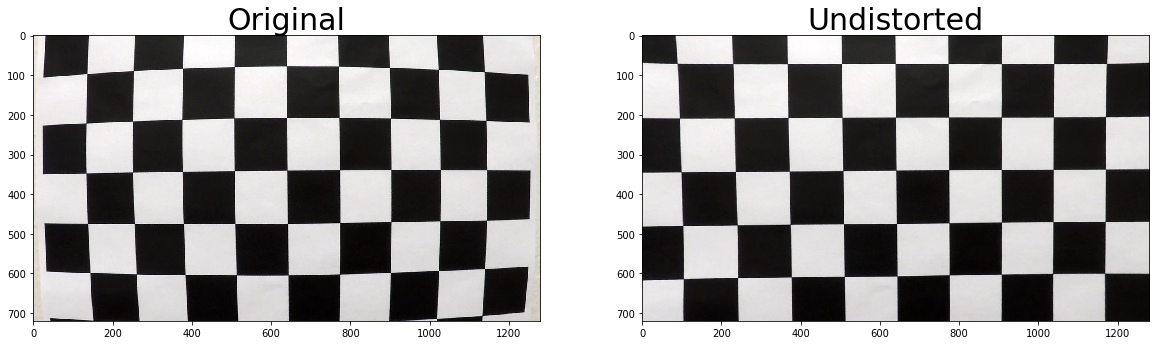

Output Images:  ['output_images/calibration1_cal_Undistorted.jpg', 'output_images/calibration1_cal_Original.jpg']


In [16]:
# Run the calibration and undistortion test
test_harness(4)

oimglist = glob.glob("output_images/*_cal_*.jpg")
print ("Output Images: ", oimglist)


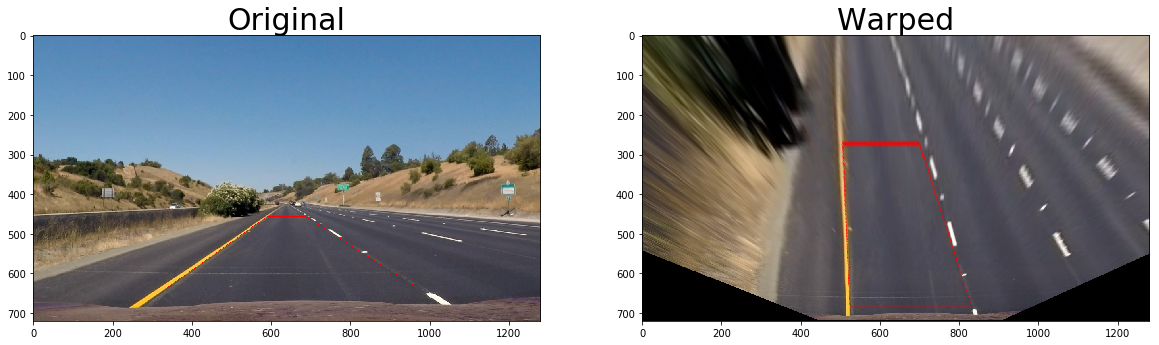

Output Images:  ['output_images/straight_lines1_persp_Warped.jpg', 'output_images/straight_lines1_persp_Original.jpg']


In [17]:
# Show the perspective transformation
test_harness(5)

oimglist = glob.glob("output_images/*_persp_*.jpg")
print ("Output Images: ", oimglist)

Processing  video_clips/project_video_clip_884.jpg


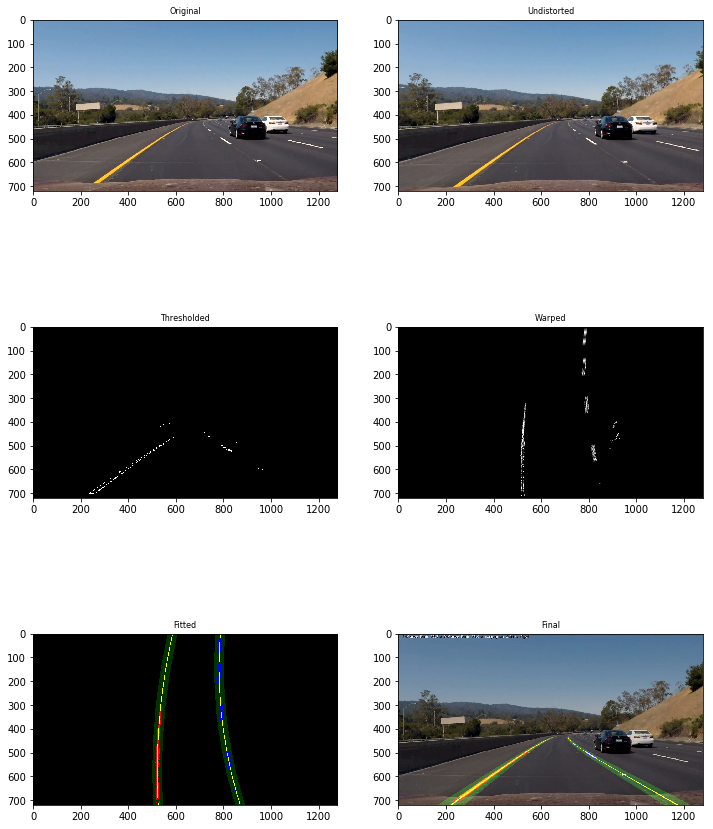

Input Images:  ['video_clips/project_video_clip_884.jpg']
Output Images:  ['output_images/project_video_clip_884_pp_Undistort.jpg', 'output_images/project_video_clip_884_pp_LaneFind.jpg', 'output_images/project_video_clip_884_pp_Final.jpg', 'output_images/project_video_clip_884_pp_Warp.jpg', 'output_images/project_video_clip_884_pp_Threshold.jpg', 'output_images/project_video_clip_884_pp_Unwarp.jpg']


In [18]:
# Run the pipeline against a single test image and show each stage's output
test_harness(3)

oimglist = glob.glob("video_clips/*_clip_884*.jpg")
print ("Input Images: ", oimglist)

oimglist = glob.glob("output_images/*884_pp_*.jpg")
print ("Output Images: ", oimglist)

In [19]:
# Run the pipeline against each of the test_images
test_harness(1)

oimglist = glob.glob("output_images/*_out.jpg")
print ("Output Images: ")
for x in oimglist: print ("  ", x) 

Processing  test_images/test5.jpg
Processing  test_images/test4.jpg
Processing  test_images/test2.jpg
Processing  test_images/test1.jpg
Processing  test_images/test6.jpg
Processing  test_images/straight_lines2.jpg
Processing  test_images/straight_lines1.jpg
Processing  test_images/test3.jpg
Input Images: 
   test_images/test5.jpg
   test_images/test4.jpg
   test_images/test2.jpg
   test_images/test1.jpg
   test_images/test6.jpg
   test_images/straight_lines2.jpg
   test_images/straight_lines1.jpg
   test_images/test3.jpg
Output Images: 
   output_images/straight_lines2_out.jpg
   output_images/test5_out.jpg
   output_images/test2_out.jpg
   output_images/straight_lines1_out.jpg
   output_images/test6_out.jpg
   output_images/test1_out.jpg
   output_images/test4_out.jpg
   output_images/test3_out.jpg


In [20]:
# Run the pipeline against the project video stream
test_harness(2)

oimglist = glob.glob("*_out.mp4")
print ("Output Images: ", oimglist)

2018-11-14 05:53:19.227735
Global configurations: 
colfilt True
fitpref True
saveclips False
drawrect False
savepipe False
savefit True
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:36<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Output Images:  ['project_video_out.mp4']


In [21]:
# Let us take a look at the video output

HTML("""
<video width="800" height="450" controls>
  <source src="{0}">
</video>
""".format("project_video_out.mp4"))